In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy import linalg as LA

In [3]:
#Create 50 independet MLPs with 1 hidden layer of 10 neurons and 1 output neuron
def MLP_1(x,n,MLP_no):
    '''Compute Output for MLP with 1 hidden layer of 10 neurons and 1 output neuron'''
    #initialize weights
    #seed the random number generator
    np.random.seed(MLP_no+100)
    w21 = np.random.normal(0, 1, (10, 1))
    w10 = np.random.normal(0, n, (10, 1))
    w20 = np.random.uniform(-2, 2, (10, 1))
    
    #Compute input for first hidden layer
    h = w10@x - w20
    #Compute activation for hidden layer
    f_h = np.tanh(h)
    #Compute output
    output = w21.T@f_h
    
    return output

In [4]:

x = np.linspace(-2,2,100).reshape(100,1)

#Add 50 columns for outputs
input_output1 = np.append(x, np.zeros((100,50)), axis=1)
input_output2 = np.append(x, np.zeros((100,50)), axis=1)

for MLP_no in np.arange(start = 1, stop = 51):
    for i in range(len(x)):
        output1 = MLP_1(x[i].reshape(1,1),2, MLP_no)
        output2 = MLP_1(x[i].reshape(1,1),0.5, MLP_no)
        input_output1[i,MLP_no] = output1
        input_output2[i,MLP_no] = output2


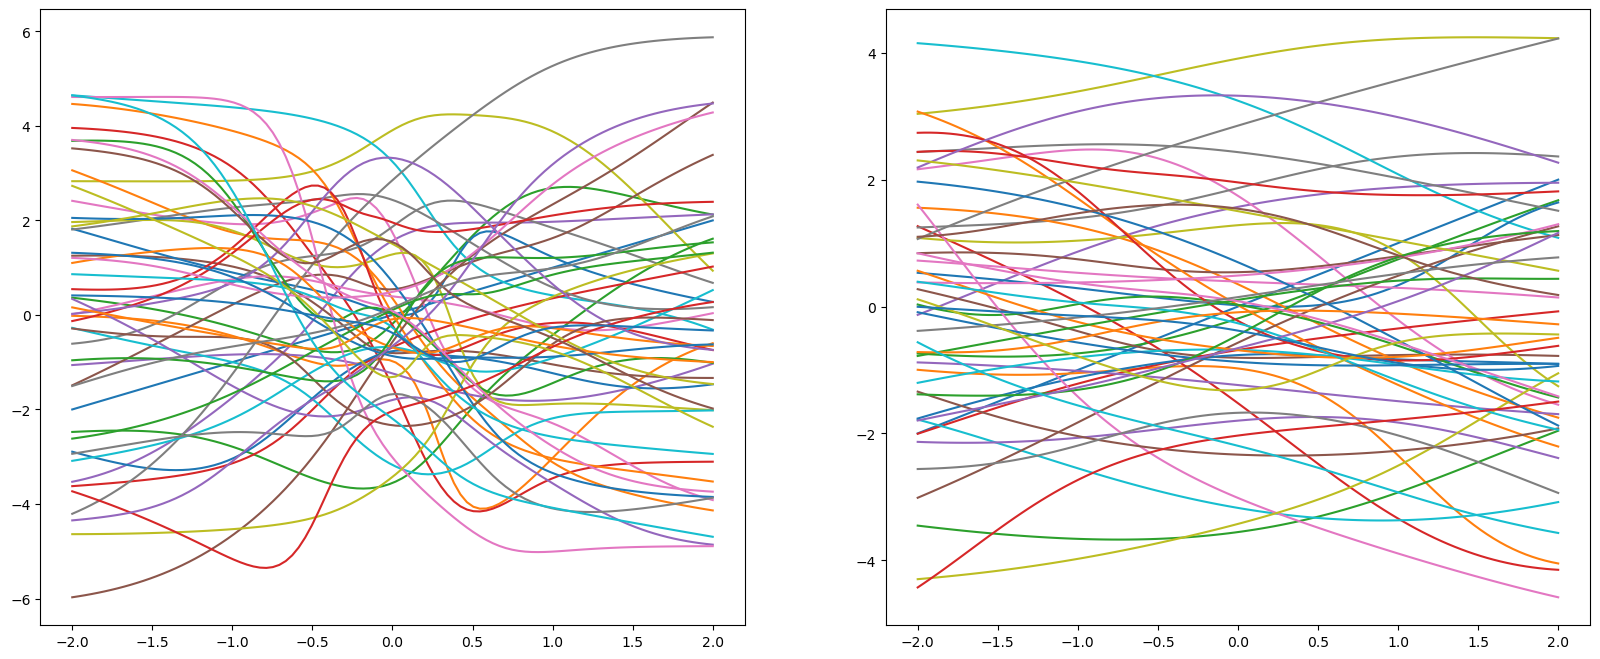

In [5]:
number_of_MLPs = np.shape(input_output1)[1]

fig = plt.figure(figsize=(20,8))

#Plot output of all 50 MLPs with initialization 1
ax1 = fig.add_subplot(1,2,1)
for i in np.arange(number_of_MLPs):
    plt.plot(input_output1[:,0], input_output1[:,i])
    
#Plot output of all 50 MLPs with initialization 2
ax2 = fig.add_subplot(1,2,2)
number_of_MLPs = np.shape(input_output2)[1]

for i in np.arange(number_of_MLPs):
    plt.plot(input_output2[:,0], input_output2[:,i])
    
plt.show()

*Compute the mean squared error (MSE) between each of these 2 × 50 (50 from each of the above two initialization procedures) input-output functions and the function g(x) = −x. For each of the two initialization procedures, which MLP approximates g best? Plot y(x) vs. x for these two MLPs
*

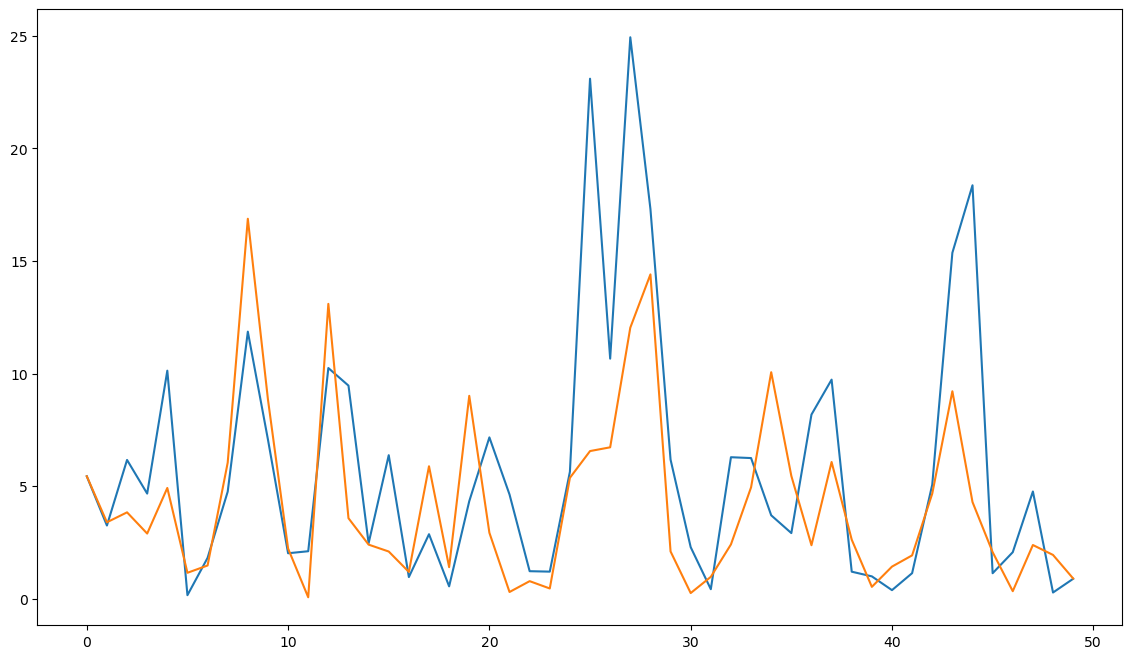

In [6]:
from sklearn.metrics import mean_squared_error

number_of_MLPs = np.shape(input_output1)[1]-1

g_function = x*-1
mse_1 = np.zeros([50,1])
mse_2 = np.zeros([50,1])

fig = plt.figure(figsize=(14,8))

for i in np.arange(number_of_MLPs)-1:
    mse_1[i] = mean_squared_error(g_function, input_output1[:,i])
    mse_2[i] = mean_squared_error(g_function, input_output2[:,i])

plt.plot((np.arange(number_of_MLPs)), mse_1)
plt.plot((np.arange(number_of_MLPs)), mse_2)

plt.show()


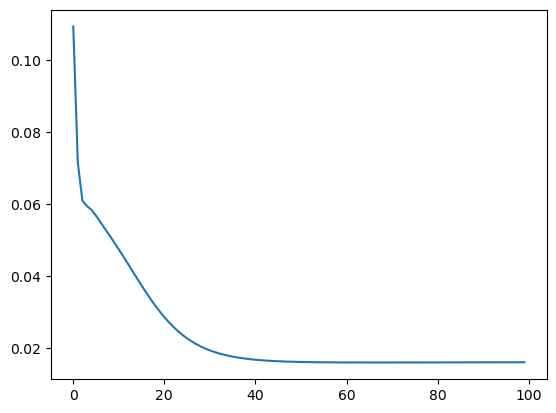

In [41]:
#fetch data from dataset
from numpy import genfromtxt
data = genfromtxt('RegressionData.csv', delimiter=' ')

np.random.seed(10)
#(A) Initialization:
#Initial weights from input node to hidden layer incl. bias (shape: 3,2)
w01_bias = np.random.uniform(-0.5, 0.5, (3, 2))
#Initial weights from hidden layer to output neuron incl. bias
w12_bias = np.random.uniform(-0.5, 0.5, (1,4))


#(B) Iterative learning:
#Innitialize
nu = 0.5
gradient01 = np.zeros([3,2])
gradient12 = np.zeros([1,4])

epoch_error_log = np.zeros(1)
for epoch in np.arange(100):
    
    for i in np.arange(data.shape[0]):
        epoch_error = 0
        x = data[i, 0].reshape(1,1)
        y = data[i, 1]
        #(a) Forward Propagation:
        #prepend bias term (shape: 2,1)
        x_bias = np.insert(x, 0, 1)
    
        #Calculate hidden layer (shape: 3,1)
        h1 = w01_bias @ x_bias
        #Calculate output layer and prepend bias term
        h2 = w12_bias @ np.insert(np.tanh(h1), 0, 1)

        #Calculate error
        error = 0.5*np.square(h2 - y)

        #Backward pass
        delta_output = 1
        delta_hidden = np.dot((1 - np.tanh(hidden_output_bias[1::])), np.sum(w12_bias[0][1:4]))

        gradient01 += nu * ((h2 - y)*delta_1).reshape(3,1) @ np.tanh(x_bias).reshape(1,2)
        gradient12 += nu * ((h2 - y)*delta_L*np.tanh(np.insert(h1,0,1))).reshape(1,4)

        #Cumulate epoch error
        epoch_error = epoch_error + error

    epoch_error_log = np.append(epoch_error_log, epoch_error/data.shape[0])
    #Update weights
    gradient01 = gradient01/data.shape[0]
    gradient12 = gradient12/data.shape[0]

    w01_bias = w01_bias - gradient01
    w12_bias = w12_bias - gradient12

plt.plot(epoch_error_log[1::])